In [1]:
import sys
sys.path.append('..') 
from helper_fun import *

from split_furthest_cluster import *
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

from time import time
import warnings

warnings.simplefilter('ignore', UserWarning)


2024-07-26 15:49:55.445705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    # distance_matrix = []
    # # Notice how we are deliberately skipping the first and last items in the list
    # # because we don't need to compare them against themselves
    # for i in range(1, len(fp_list)):
    #     # Compare the current fingerprint against all the previous ones in the list
    #     similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
    #     # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
    #     distance_matrix.extend([1 - x for x in similarities])
    # return distance_matrix
    n = len(fp_list)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i):
            similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            distance = 1 - similarity
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Mirror the distance
    
    return distance_matrix

def assign_cluster_id(df_data, cluster_labels):
    '''df_data is a data frame that contains only CID and SMILES columns
    '''
    print('\nAssign cluster ID')
    # Count the size of each cluster
    cluster_sizes = pd.Series(cluster_labels).value_counts()
    # Create a mapping from old cluster ID to new cluster ID based on size
    cluster_mapping = {old: new for new, old in enumerate(cluster_sizes.index)}
    # Reassign cluster IDs
    df_data.loc[:, 'Cluster_ID'] = pd.Series(cluster_labels).map(cluster_mapping)
    return df_data

#define a function that takes in a list of fingerprints and a cutoff value and returns the equivalent cluster labels
def hierarchical_cluster_fingerprints(table, distance_threshold=0.12, CID_column='CID', SMILES_column='SMILES', pIC50_column='f_avg_pIC50'):
    """Cluster fingerprints
    Input: whole dataframe (compounds)
    Parameters:
        fingerprints
        cutoff: threshold for the clustering, 0.2 is usual
    """

    t0 = time()
    # Generate fingerprints
    compounds_list = [(Chem.MolFromSmiles(smiles), chembl_id) for _, chembl_id, smiles in table[[CID_column, SMILES_column]].itertuples()]
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds_list]

    # Perform hierarchical clustering
    df_data = table[[CID_column, SMILES_column, pIC50_column]].copy()
    df_data.loc[:, "Fingerprints"] = df_data[SMILES_column].apply(smiles_to_fp)

    # Calculate the Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Perform agglomerative clustering
    cluster = AgglomerativeClustering(metric="euclidean", linkage='ward', distance_threshold=distance_threshold, n_clusters=None)
    cluster.fit(distance_matrix)


    tf = time() - t0
    # Assign cluster ID
    df_clusters = assign_cluster_id(df_data, cluster.labels_)
    # Metrics
    s1 = silhouette_score(distance_matrix, cluster.labels_, metric='euclidean')
    c1 = calinski_harabasz_score(distance_matrix, cluster.labels_)
    d1 = davies_bouldin_score(distance_matrix, cluster.labels_)
    df_metrics = pd.DataFrame(data=[[tf, s1, c1, d1]],
                              columns=['Time', 'Silhouette', 'CH score', 'DB score'])
    return df_metrics, df_clusters


In [3]:
def plot_cluster_hist(table, distance_threshold=0.2, CID_column='CID', SMILES_column='SMILES', pIC50_column="f_avg_pIC50", Cluster_ID='Cluster_ID'):
    df_metrics, df_clusters = hierarchical_cluster_fingerprints(table, distance_threshold=distance_threshold, CID_column=CID_column, SMILES_column=SMILES_column, pIC50_column=pIC50_column)
    plt.figure(figsize=(15, 4))
    plt.hist(df_clusters[Cluster_ID], bins=len(df_clusters[Cluster_ID].unique()))
    plt.xlabel('Cluster ID')
    plt.ylabel('Cluster size')
    plt.title(f'Cluster size distribution: distance_threshold={distance_threshold}')
    return plt.show()

In [4]:


def split_hierarchical_clusters(table, test_size=0.2, random_state=42, distance_threshold=0.2, CID_column='CID', SMILES_column='SMILES', pIC50_column='f_avg_pIC50', shuffle=True, stratify=None):
    """Split the data based on the cluster ID
    """
    # Set the random seed for reproducibility
    np.random.seed(random_state)
    
    df_metrics, df_clusters = hierarchical_cluster_fingerprints(table, distance_threshold=distance_threshold, CID_column=CID_column, SMILES_column=SMILES_column, pIC50_column=pIC50_column)
    df_data = table[[CID_column, SMILES_column, pIC50_column]].copy()
    df_data.loc[:, "Fingerprints"] = df_data[SMILES_column].apply(smiles_to_fp)
    # Get the unique cluster IDs
    unique_clusters = df_clusters['Cluster_ID'].unique()
    
    # Split the clusters into training and testing sets
    train_clusters, test_clusters = train_test_split(unique_clusters, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=stratify)
    
    # Get the indices of the training and testing data
    train_indices = df_clusters.index[df_clusters['Cluster_ID'].isin(train_clusters)]
    test_indices = df_clusters.index[df_clusters['Cluster_ID'].isin(test_clusters)]
    
    # Get the training and testing data
    X_train = df_data.loc[train_indices, 'Fingerprints']
    X_test = df_data.loc[test_indices, 'Fingerprints']
    y_train = df_data.loc[train_indices, 'f_avg_pIC50']
    y_test = df_data.loc[test_indices, 'f_avg_pIC50']
    
    return X_train, X_test, y_train, y_test

In [5]:
# Create molecules from SMILES and store in array
compounds = pd.read_csv("../COVID_MOONSHOT/compounds_filtered.csv")

# df_metrics, df_clusters = hierarchical_cluster_fingerprints(compounds)
# # print(df_metrics)
# print(df_clusters)


Assign cluster ID


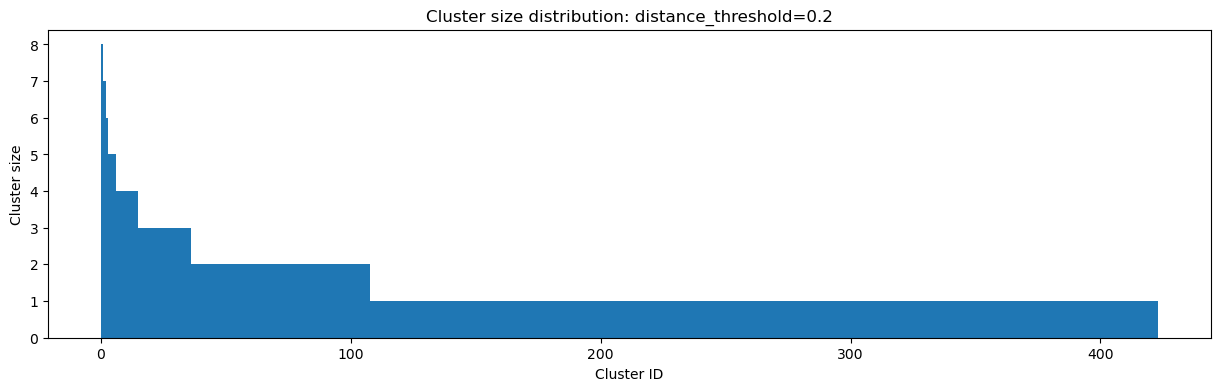


Assign cluster ID


(       Time  Silhouette      CH score  DB score
 0  8.315394    0.444689  11845.507041  0.059614,
                      CID                                          SMILES  \
 0    DAR-DIA-23aa0b97-19              N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1   
 1    DAR-DIA-23aa0b97-20                   O=C(Cc1cncc2ccccc12)Nc1ccccc1   
 2     TRY-UNI-714a760b-3                 Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1   
 3     TRY-UNI-714a760b-6                    Cc1ccncc1NC(=O)Cc1cccc(Cl)c1   
 4    TRY-UNI-714a760b-12                    Cc1ccncc1NC(=O)Nc1cccc(Cl)c1   
 ..                   ...                                             ...   
 590   RHE-UNK-eb059eb9-1       Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1   
 591   HYO-UNK-49a60884-1                 O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1   
 592   PET-UNK-bcc8fd08-1  CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21   
 593  BEN-DND-03406596-10          O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1   
 594   MAT-POS-d8472c4f-5          O=C(Nc1cncc2ccccc12

In [6]:
plot_cluster_hist(compounds, distance_threshold=0.2, CID_column='CID', SMILES_column='SMILES', Cluster_ID='Cluster_ID')
hierarchical_cluster_fingerprints(compounds, distance_threshold=0.2, CID_column='CID', SMILES_column='SMILES')

In [7]:
# Example usage
X_train, X_test, y_train, y_test = split_hierarchical_clusters(compounds)

# print(f"X_train shape: {type(X_train)}")
# print(f"y_train shape: {type(y_train)}")
# print(f"X_test shape: {type(X_test)}")
# print(f"y_test shape: {type(y_test)}")


Assign cluster ID
